In [58]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.python.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.wrappers.scikit_learn import KerasRegressor

In [59]:
os.getcwd()
df = pd.read_csv('SeoulBikeData.csv', encoding= 'unicode_escape')

In [60]:
%timeit pd.to_datetime(df['Date'], infer_datetime_format=True)
df['Date']= pd.to_datetime(df['Date'],dayfirst = True)
df['Day of week'] = pd.DatetimeIndex(df['Date']).day_name()

2.49 ms ± 452 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [61]:
#Data cleaning: Turn categorical variables into binary variables. 
cleanup = {"Holiday": {"No Holiday": 0, "Holiday": 1 },
            "Functioning Day": {"Yes": 1, "No": 0 },
            "Day of week": {"Monday": 0, "Tuesday": 0, "Wednesday": 0, "Thursday": 0, "Friday": 0, "Saturday": 1, "Sunday": 1 }}
df = df.replace(cleanup)
df = pd.get_dummies(df, columns=["Seasons"], prefix=["Season"]) #convert to one-hot

#Drop unnecessary variables and samples with 0 target value.
df = df.drop(columns=['Date', 'Functioning Day']) 
index_names = df[ df['Rented Bike Count'] == 0 ].index
df.drop(index_names, inplace = True)
df.head(20)

,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Holiday,Day of week,Season_Autumn,Season_Spring,Season_Summer,Season_Winter
0,254,0,-5.2,37,2.2,2000,-17.6,0.00,0.0,0.0,0,0,0,0,0,1
1,204,1,-5.5,38,0.8,2000,-17.6,0.00,0.0,0.0,0,0,0,0,0,1
2,173,2,-6.0,39,1.0,2000,-17.7,0.00,0.0,0.0,0,0,0,0,0,1
3,107,3,-6.2,40,0.9,2000,-17.6,0.00,0.0,0.0,0,0,0,0,0,1
4,78,4,-6.0,36,2.3,2000,-18.6,0.00,0.0,0.0,0,0,0,0,0,1
5,100,5,-6.4,37,1.5,2000,-18.7,0.00,0.0,0.0,0,0,0,0,0,1
6,181,6,-6.6,35,1.3,2000,-19.5,0.00,0.0,0.0,0,0,0,0,0,1
7,460,7,-7.4,38,0.9,2000,-19.3,0.00,0.0,0.0,0,0,0,0,0,1
8,930,8,-7.6,37,1.1,2000,-19.8,0.01,0.0,0.0,0,0,0,0,0,1
9,490,9,-6.5,27,0.5,1928,-22.4,0.23,0.0,0.0,0,0,0,0,0,1


In [62]:
#Split training and test data.
X = df.values[:, 1:]
y = df.values[:, 0]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

In [63]:
#Normalize and rescale the data.
X_train_norm = (X_train - np.mean(X_train, 0)) / np.std(X_train, 0)
X_test_norm = (X_test - np.mean(X_test, 0)) / np.std(X_test, 0)
y_train_norm = (y_train - np.mean(y_train, 0)) / np.std(y_train, 0)
y_test_norm = (y_test - np.mean(y_test, 0)) / np.std(y_test, 0)
X_train_scale = (X_train_norm - np.amin(X_train_norm, 0))/(np.amax(X_train_norm, 0) - np.amin(X_train_norm, 0))
X_test_scale = (X_test_norm - np.amin(X_test_norm, 0))/(np.amax(X_test_norm, 0) - np.amin(X_test_norm, 0))
y_train_scale = (y_train_norm - np.amin(y_train_norm, 0))/(np.amax(y_train_norm, 0) - np.amin(y_train_norm, 0))
y_test_scale = (y_test_norm - np.amin(y_test_norm, 0))/(np.amax(y_test_norm, 0) - np.amin(y_test_norm, 0))

In [64]:
tf.keras.backend.clear_session()

In [65]:
#Build the neural network model
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(15, input_dim=15, kernel_initializer='normal', activation='relu'))
model.add(tf.keras.layers.Dense(370, activation='relu'))
model.add(tf.keras.layers.Dense(370, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='linear'))
model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(0.001), metrics=['mse','mae'])

In [66]:
#Fit the model
##Epochs =400, Batch size = 300
history = model.fit(X_train_scale, y_train_scale, epochs=400, batch_size=300, verbose=1, validation_split=0.2)
predictions = model.predict(X_test_scale)

Epoch 1/400
16/16 [==============================] - 1s 24ms/step - loss: 0.0405 - mse: 0.0405 - mae: 0.1528 - val_loss: 0.0227 - val_mse: 0.0227 - val_mae: 0.1106
Epoch 2/400
16/16 [==============================] - 0s 8ms/step - loss: 0.0218 - mse: 0.0218 - mae: 0.1110 - val_loss: 0.0165 - val_mse: 0.0165 - val_mae: 0.0995
Epoch 3/400
16/16 [==============================] - 0s 10ms/step - loss: 0.0168 - mse: 0.0168 - mae: 0.0939 - val_loss: 0.0137 - val_mse: 0.0137 - val_mae: 0.0865
Epoch 4/400
16/16 [==============================] - 0s 7ms/step - loss: 0.0151 - mse: 0.0151 - mae: 0.0871 - val_loss: 0.0127 - val_mse: 0.0127 - val_mae: 0.0796
Epoch 5/400
16/16 [==============================] - 0s 8ms/step - loss: 0.0142 - mse: 0.0142 - mae: 0.0835 - val_loss: 0.0122 - val_mse: 0.0122 - val_mae: 0.0782
Epoch 6/400
16/16 [==============================] - 0s 7ms/step - loss: 0.0132 - mse: 0.0132 - mae: 0.0808 - val_loss: 0.0120 - val_mse: 0.0120 - val_mae: 0.0793
Epoch 7/400
16/16 [=

dict_keys(['loss', 'mse', 'mae', 'val_loss', 'val_mse', 'val_mae'])


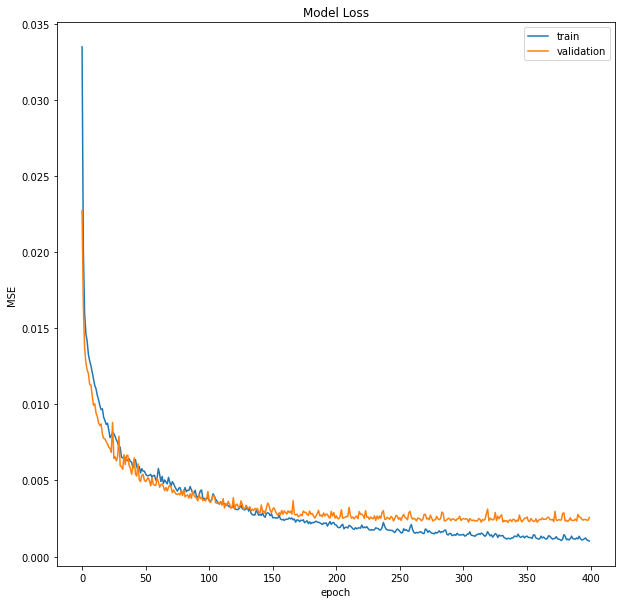

In [67]:
print(history.history.keys())
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.rcParams["figure.figsize"] = (15,15)
plt.show()
#Genreate the training and validation loss plot.

In [68]:
#Scale back the predictions to the original scale and denormalize.
predictions_descale = predictions*(np.amax(y_test_norm, 0) - np.amin(y_test_norm, 0)) + np.amin(y_test_norm, 0)
predictions_orig = predictions_descale*np.std(y_test, 0) + np.mean(y_test, 0)
predictions_orig

array([[  82.0733 ],
       [ 374.4739 ],
       [ 415.20557],
       ...,
       [1296.885  ],
       [ 172.88477],
       [ 967.702  ]], dtype=float32)

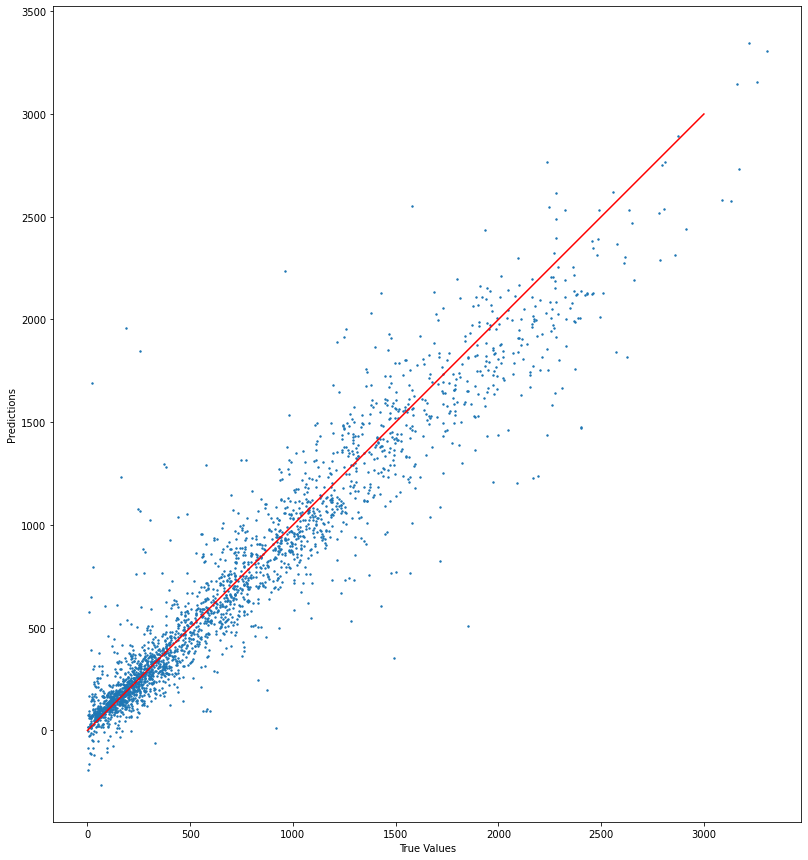

In [69]:
#Predictions vs Ture Value Scatter plot
a = plt.axes(aspect='equal')
plt.scatter(y_test, predictions_orig, s=2)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.plot([0,3000], [0,3000], c="red")
plt.rcParams["figure.figsize"] = (20,20)

In [80]:
y_test = y_test.reshape((y_test.size,1))
error = (predictions_orig - y_test)/y_test * 100
np.mean(error)

17.568171523474533

In [82]:
np.mean(y_test)

724.8685039370079

In [83]:
np.mean(predictions_orig)

704.1839

In [71]:
#MAE error
sklearn.metrics.mean_absolute_error(y_test, predictions_orig)

120.35266721229854

In [72]:
#RMSE error
math.sqrt(sklearn.metrics.mean_squared_error(y_test, predictions_orig))

193.93846774390994

In [73]:
#R^2
sklearn.metrics.r2_score(y_test, predictions_orig)

0.9070776339184097

In [74]:
error_df = pd.DataFrame(error, columns = ['error'])
error_df

,error
0,-4.565926
1,68.681940
2,-9.933717
3,67.037237
4,6.762667
...,...
2535,130.208813
2536,7.918017
2537,247.690351
2538,-37.586727


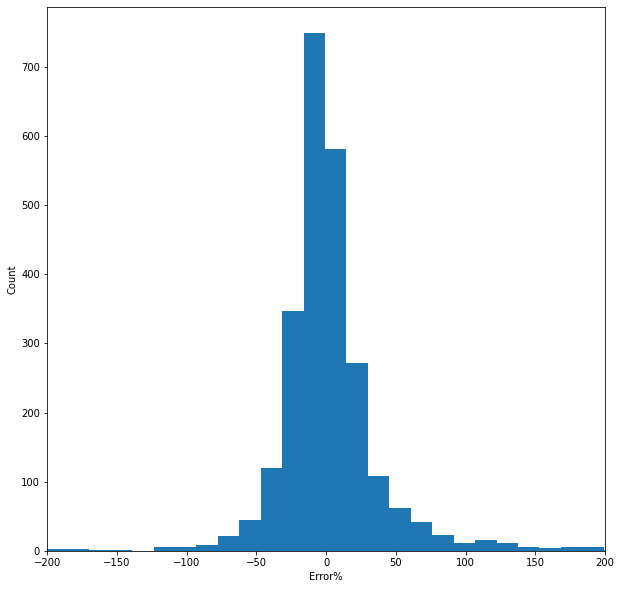

In [88]:
plt.hist(error_df, density=False, bins = 800)  # density=False would make counts
plt.xlim([-200,200])
plt.ylabel('Count')
plt.xlabel('Error%')
plt.rcParams["figure.figsize"] = (10,10)
#Plot the error percentage ditribution histogram

In [89]:
model.save('epochs=400')

INFO:tensorflow:Assets written to: epochs=400\assets


In [90]:
reload = tf.keras.models.load_model('epochs=400')

In [ ]:
#Epochs = 200

In [102]:

tf.keras.backend.clear_session()
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(15, input_dim=15, kernel_initializer='normal', activation='relu'))
model.add(tf.keras.layers.Dense(370, activation='relu'))
model.add(tf.keras.layers.Dense(370, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='linear'))
model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(0.001), metrics=['mse','mae'])
history2 = model.fit(X_train_scale, y_train_scale, epochs=200, batch_size=300, verbose=1, validation_split=0.2)
predictions = model.predict(X_test_scale)

Epoch 1/200
16/16 [==============================] - 1s 17ms/step - loss: 0.0451 - mse: 0.0451 - mae: 0.1581 - val_loss: 0.0221 - val_mse: 0.0221 - val_mae: 0.1001
Epoch 2/200
16/16 [==============================] - 0s 10ms/step - loss: 0.0202 - mse: 0.0202 - mae: 0.1008 - val_loss: 0.0164 - val_mse: 0.0164 - val_mae: 0.0970
Epoch 3/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0165 - mse: 0.0165 - mae: 0.0927 - val_loss: 0.0141 - val_mse: 0.0141 - val_mae: 0.0857
Epoch 4/200
16/16 [==============================] - ETA: 0s - loss: 0.0154 - mse: 0.0154 - mae: 0.088 - 0s 7ms/step - loss: 0.0153 - mse: 0.0153 - mae: 0.0879 - val_loss: 0.0136 - val_mse: 0.0136 - val_mae: 0.0872
Epoch 5/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0139 - mse: 0.0139 - mae: 0.0833 - val_loss: 0.0122 - val_mse: 0.0122 - val_mae: 0.0775
Epoch 6/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0139 - mse: 0.0139 - mae: 0.0828 - val_loss: 0.0121 - va

dict_keys(['loss', 'mse', 'mae', 'val_loss', 'val_mse', 'val_mae'])


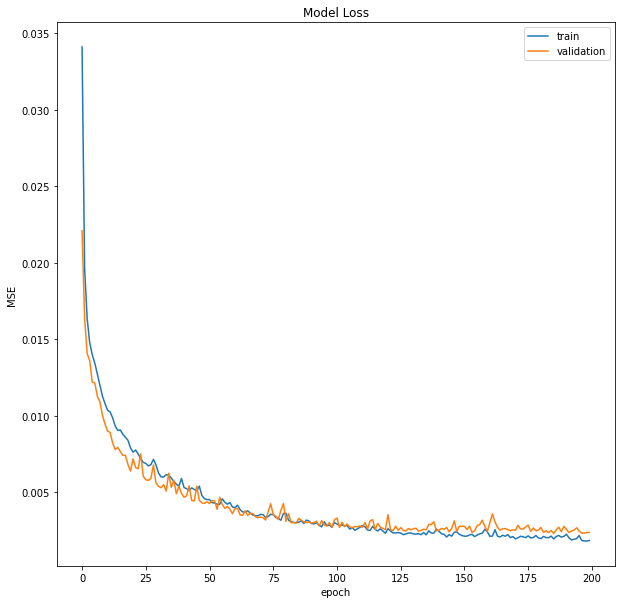

In [103]:
print(history2.history.keys())
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.rcParams["figure.figsize"] = (15,15)
plt.show()
#Genreate the training and validation loss plot.

In [104]:
#Scale back the predictions to the original scale and denormalize.
predictions_descale = predictions*(np.amax(y_test_norm, 0) - np.amin(y_test_norm, 0)) + np.amin(y_test_norm, 0)
predictions_orig = predictions_descale*np.std(y_test, 0) + np.mean(y_test, 0)
predictions_orig

array([[  80.19244628],
       [ 595.13910531],
       [ 346.98451456],
       ...,
       [1232.39793404],
       [ 241.81689626],
       [ 980.85294595]])

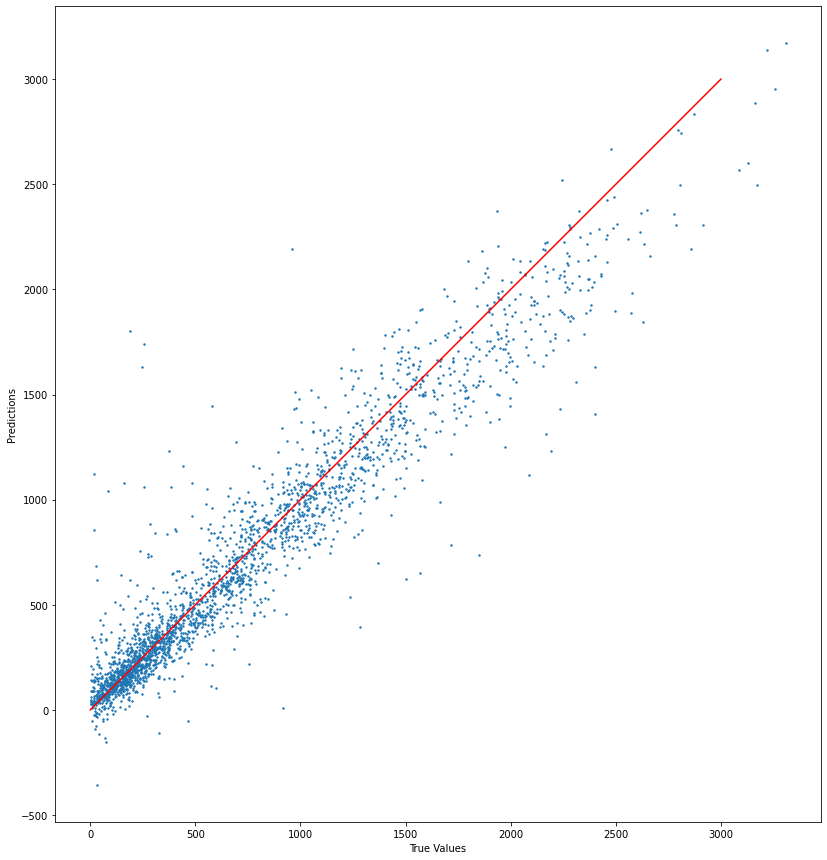

In [105]:
#Predictions vs Ture Value Scatter plot
a = plt.axes(aspect='equal')
plt.scatter(y_test, predictions_orig, s=2)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.plot([0,3000], [0,3000], c="red")
plt.rcParams["figure.figsize"] = (20,20)

In [113]:
y_test = y_test.reshape((y_test.size,1))
error = (predictions_orig - y_test)/y_test * 100
np.mean(error)

25.38120995407786

In [114]:
np.mean(y_test)

724.8685039370079

In [115]:
np.mean(predictions_orig)

698.4316917130102

In [107]:
#MAE error
sklearn.metrics.mean_absolute_error(y_test, predictions_orig)

119.5946352623933

In [108]:
#RMSE error
math.sqrt(sklearn.metrics.mean_squared_error(y_test, predictions_orig))

188.7185999742116

In [109]:
#R^2
sklearn.metrics.r2_score(y_test, predictions_orig)

0.9120123432930735

In [110]:
error_df = pd.DataFrame(error, columns = ['error'])
error_df

,error
0,-6.752969
1,168.080678
2,-24.732209
3,31.871874
4,9.869060
...,...
2535,113.051641
2536,-4.842942
2537,230.401591
2538,-12.701481


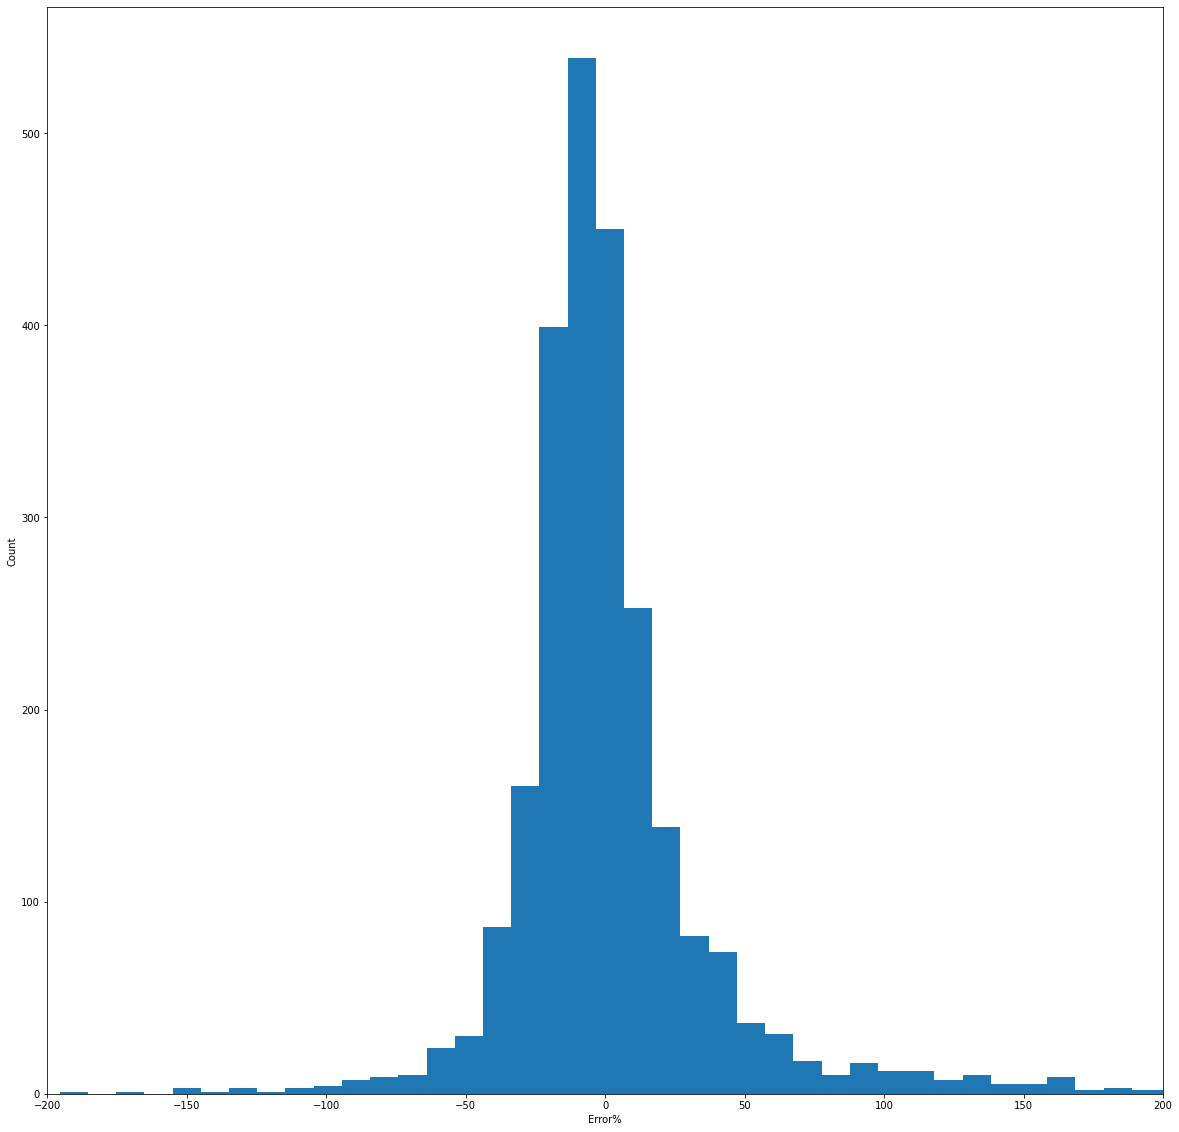

In [111]:
plt.hist(error_df, density=False, bins = 800)  # density=False would make counts
plt.xlim([-200,200])
plt.ylabel('Count')
plt.xlabel('Error%')
plt.rcParams["figure.figsize"] = (10,10)
#Plot the error percentage ditribution histogram

In [112]:
model.save('epochs=200')

INFO:tensorflow:Assets written to: epochs=200\assets


In [ ]:
#Epochs = 600

In [116]:

tf.keras.backend.clear_session()
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(15, input_dim=15, kernel_initializer='normal', activation='relu'))
model.add(tf.keras.layers.Dense(370, activation='relu'))
model.add(tf.keras.layers.Dense(370, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='linear'))
model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(0.001), metrics=['mse','mae'])
history2 = model.fit(X_train_scale, y_train_scale, epochs=600, batch_size=300, verbose=1, validation_split=0.2)
predictions = model.predict(X_test_scale)

Epoch 1/600
16/16 [==============================] - 1s 17ms/step - loss: 0.0483 - mse: 0.0483 - mae: 0.1637 - val_loss: 0.0217 - val_mse: 0.0217 - val_mae: 0.1071
Epoch 2/600
16/16 [==============================] - 0s 8ms/step - loss: 0.0218 - mse: 0.0218 - mae: 0.1073 - val_loss: 0.0153 - val_mse: 0.0153 - val_mae: 0.0910
Epoch 3/600
16/16 [==============================] - 0s 7ms/step - loss: 0.0161 - mse: 0.0161 - mae: 0.0927 - val_loss: 0.0139 - val_mse: 0.0139 - val_mae: 0.0881
Epoch 4/600
16/16 [==============================] - 0s 7ms/step - loss: 0.0145 - mse: 0.0145 - mae: 0.0865 - val_loss: 0.0128 - val_mse: 0.0128 - val_mae: 0.0833
Epoch 5/600
16/16 [==============================] - 0s 7ms/step - loss: 0.0131 - mse: 0.0131 - mae: 0.0800 - val_loss: 0.0119 - val_mse: 0.0119 - val_mae: 0.0791
Epoch 6/600
16/16 [==============================] - 0s 7ms/step - loss: 0.0131 - mse: 0.0131 - mae: 0.0805 - val_loss: 0.0116 - val_mse: 0.0116 - val_mae: 0.0793
Epoch 7/600
16/16 [==

dict_keys(['loss', 'mse', 'mae', 'val_loss', 'val_mse', 'val_mae'])


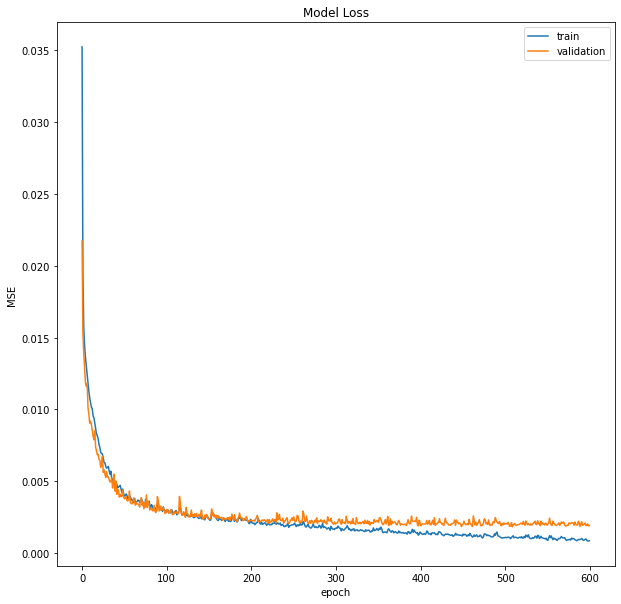

In [117]:
print(history2.history.keys())
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.rcParams["figure.figsize"] = (15,15)
plt.show()
#Genreate the training and validation loss plot.

In [118]:
#Scale back the predictions to the original scale and denormalize.
predictions_descale = predictions*(np.amax(y_test_norm, 0) - np.amin(y_test_norm, 0)) + np.amin(y_test_norm, 0)
predictions_orig = predictions_descale*np.std(y_test, 0) + np.mean(y_test, 0)
predictions_orig

array([[  60.73438839],
       [  23.62310192],
       [ 478.91680307],
       ...,
       [1308.14100192],
       [ 219.15459699],
       [ 878.1837387 ]])

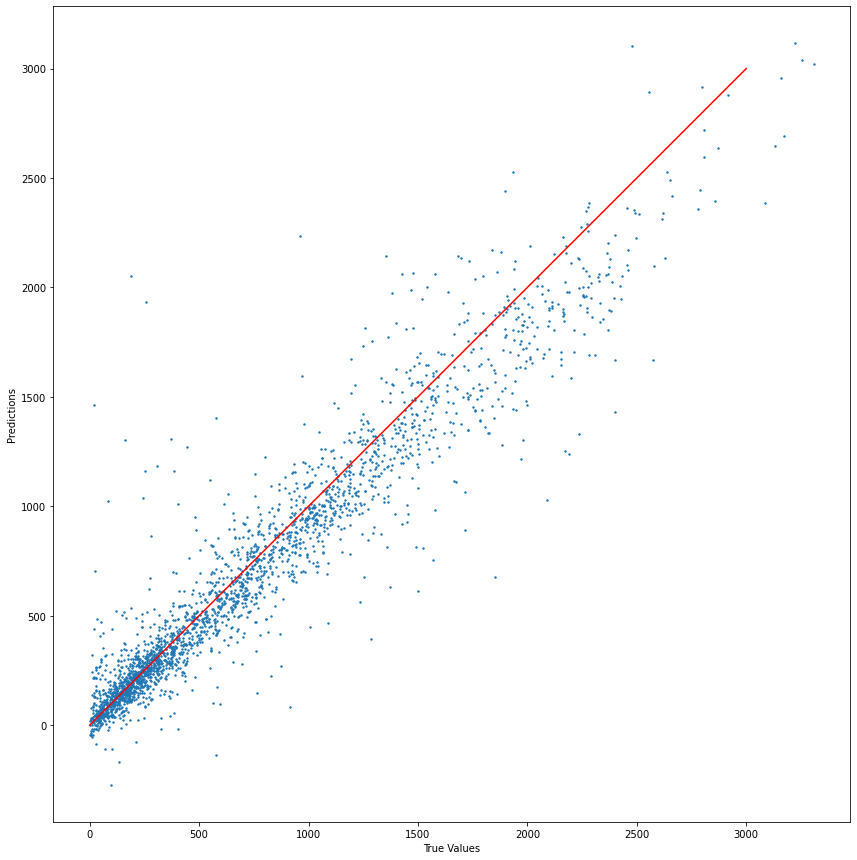

In [119]:
#Predictions vs Ture Value Scatter plot
a = plt.axes(aspect='equal')
plt.scatter(y_test, predictions_orig, s=2)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.plot([0,3000], [0,3000], c="red")
plt.rcParams["figure.figsize"] = (20,20)

In [120]:
y_test = y_test.reshape((y_test.size,1))
error = (predictions_orig - y_test)/y_test * 100
np.mean(error)

13.873913206493214

In [121]:
np.mean(y_test)

724.8685039370079

In [122]:
np.mean(predictions_orig)

684.7047765808917

In [123]:
#MAE error
sklearn.metrics.mean_absolute_error(y_test, predictions_orig)

121.94778444676653

In [124]:
#RMSE error
math.sqrt(sklearn.metrics.mean_squared_error(y_test, predictions_orig))

196.40916893423554

In [125]:
#R^2
sklearn.metrics.r2_score(y_test, predictions_orig)

0.9046949627020383

In [126]:
error_df = pd.DataFrame(error, columns = ['error'])
error_df

,error
0,-29.378618
1,-89.358963
2,3.886508
3,-19.133623
4,5.304236
...,...
2535,150.214351
2536,-23.002589
2537,250.708043
2538,-20.882817


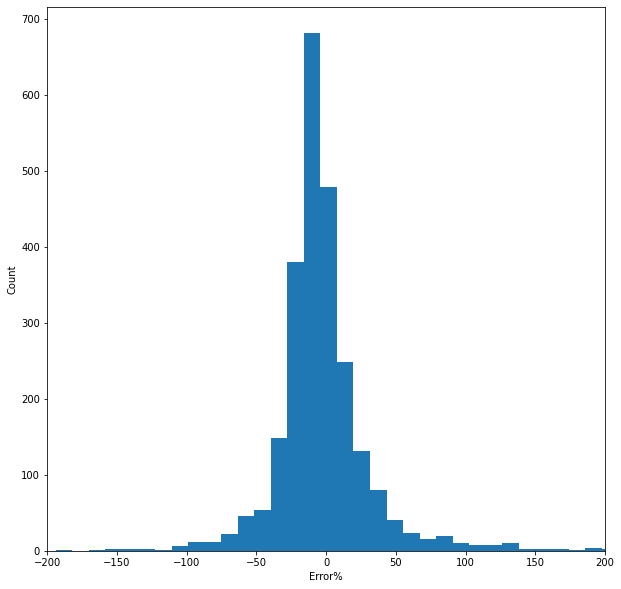

In [128]:
plt.hist(error_df, density=False, bins = 800)  # density=False would make counts
plt.xlim([-200,200])
plt.ylabel('Count')
plt.xlabel('Error%')
plt.rcParams["figure.figsize"] = (10,10)
#Plot the error percentage ditribution histogram

In [130]:
X_test.shape

(2540, 15)